In [1]:
%env CUDA_LAUNCH_BLOCKING=1
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_LAUNCH_BLOCKING=1
env: CUDA_VISIBLE_DEVICES=1


In [2]:
# Copyright (c) Facebook, Inc. and its affiliates. All rights reserved.

# Deform a source mesh to form a target mesh using 3D loss functions

In this tutorial, we learn to deform an initial generic shape (e.g. sphere) to fit a target shape.

We will cover: 

- How to **load a mesh** from an `.obj` file
- How to use the PyTorch3d **Meshes** datastructure
- How to use 4 different PyTorch3d **mesh loss functions**
- How to set up an **optimization loop**


Starting from a sphere mesh, we learn the offset to each vertex in the mesh such that
the predicted mesh is closer to the target mesh at each optimization step. To achieve this we minimize:

+ `chamfer_distance`, the distance between the predicted (deformed) and target mesh, defined as the chamfer distance between the set of pointclouds resulting from **differentiably sampling points** from their surfaces. 

However, solely minimizing the chamfer distance between the predicted and the target mesh will lead to a non-smooth shape (verify this by setting  `w_chamfer=1.0` and all other weights to `0.0`). 

We enforce smoothness by adding **shape regularizers** to the objective. Namely, we add:

+ `mesh_edge_length`, which minimizes the length of the edges in the predicted mesh.
+ `mesh_normal_consistency`, which enforces consistency across the normals of neighboring faces.
+ `mesh_laplacian_smoothing`, which is the laplacian regularizer.

## 0. Import modules

In [3]:
import os
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes, Textures
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from pytorch3d.renderer import (
    OpenGLPerspectiveCameras, look_at_view_transform, look_at_rotation, 
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SilhouetteShader, PhongShader, PointLights
)
import numpy as np
from tqdm import tqdm_notebook
%matplotlib notebook 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
device = torch.device("cuda:0")

## 1. Load an obj file and create a Meshes object

In [4]:
# The path to the target 3D model we wish to fit
# e.g. download https://free3d.com/3d-model/-dolphin-v1--12175.html and save in ./data/dolphin
trg_obj = os.path.join('./data/dolphin', '10014_dolphin_v2_max2011_it2.obj')

In [5]:
# We read the target 3D model using load_obj
verts, faces, aux = load_obj(trg_obj)

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0). 
# (scale, center) will be used to bring the predicted mesh to its original center and scale
# Note that normalizing the target mesh, speeds up the optimization but is not necessary!
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = Textures(verts_rgb=verts_rgb.to(device))

# We construct a Meshes structure for the target mesh
trg_mesh = Meshes(verts=[verts], faces=[faces_idx], 
                  textures=textures)

In [6]:
# We initialize the source shape to be a sphere of radius 1
src_mesh = ico_sphere(4, device)

###  Visualize the source and target meshes

In [7]:
def plot_pointcloud(mesh, title=""):
    verts = mesh.verts_packed()
    faces = mesh.faces_packed()
    x, y, z = verts.clone().detach().cpu().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    plt.show()

<IPython.core.display.Javascript object>


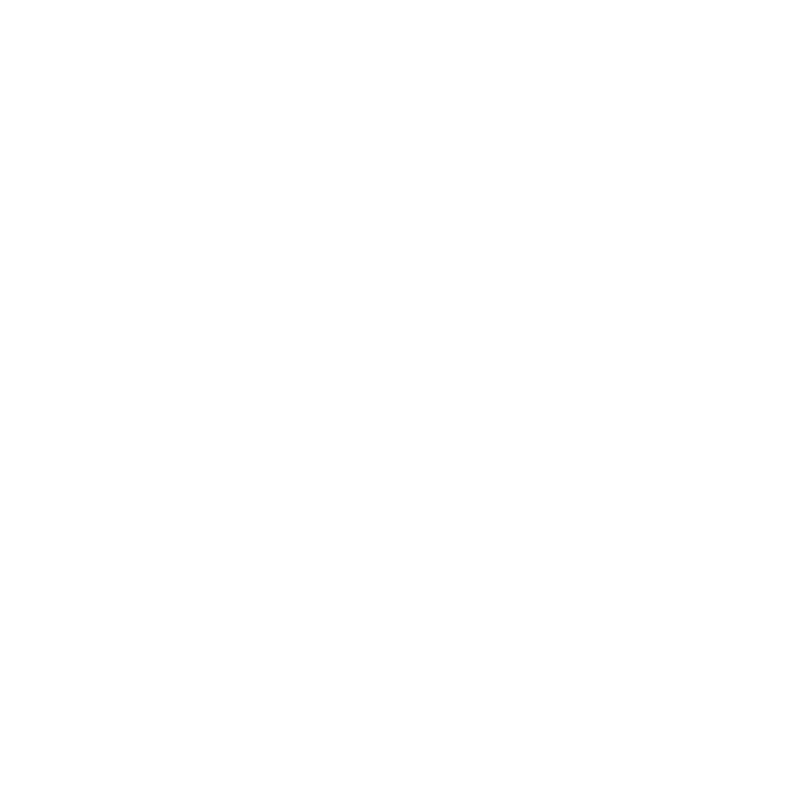

<IPython.core.display.Javascript object>


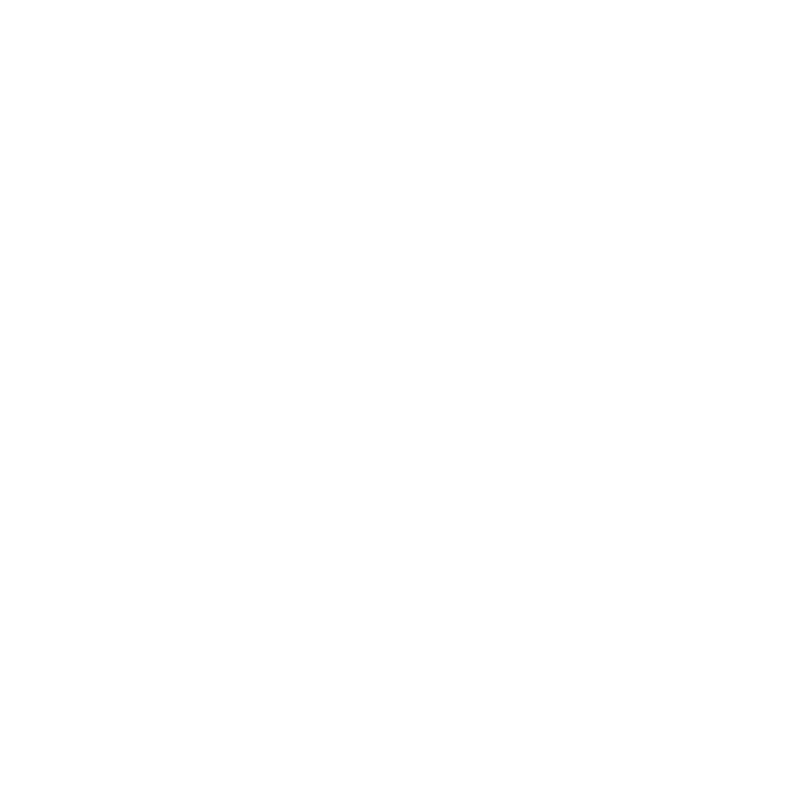

In [8]:
%matplotlib notebook
plot_pointcloud(trg_mesh, "Target mesh")
plot_pointcloud(src_mesh, "Source mesh")

# Get images from different angles

In [9]:
# Initialize an OpenGL perspective camera.
cameras = OpenGLPerspectiveCameras(device=device)

# To blend the 100 faces we set a few parameters which control the opacity and the sharpness of 
# edges. Refer to blending.py for more details. 
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 256x256. To form the blended image we use 100 faces for each pixel. Refer to rasterize_meshes.py
# for an explanation of this parameter. 
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=100, 
    bin_size=0
)

# Create a silhouette mesh renderer by composing a rasterizer and a shader. 
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SilhouetteShader(blend_params=blend_params)
)


# We will also create a phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
    bin_size=0
)
# We can add a point light in front of the object. 
lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=PhongShader(device=device, lights=lights)
)

In [10]:
look_at_view_transform(3, 0.0, 90.0, device='cpu')

(tensor([[[-4.3711e-08,  0.0000e+00, -1.0000e+00],
          [ 0.0000e+00,  1.0000e+00,  0.0000e+00],
          [ 1.0000e+00,  0.0000e+00, -4.3711e-08]]]),
 tensor([[-0., -0., 3.]]))

<IPython.core.display.Javascript object>


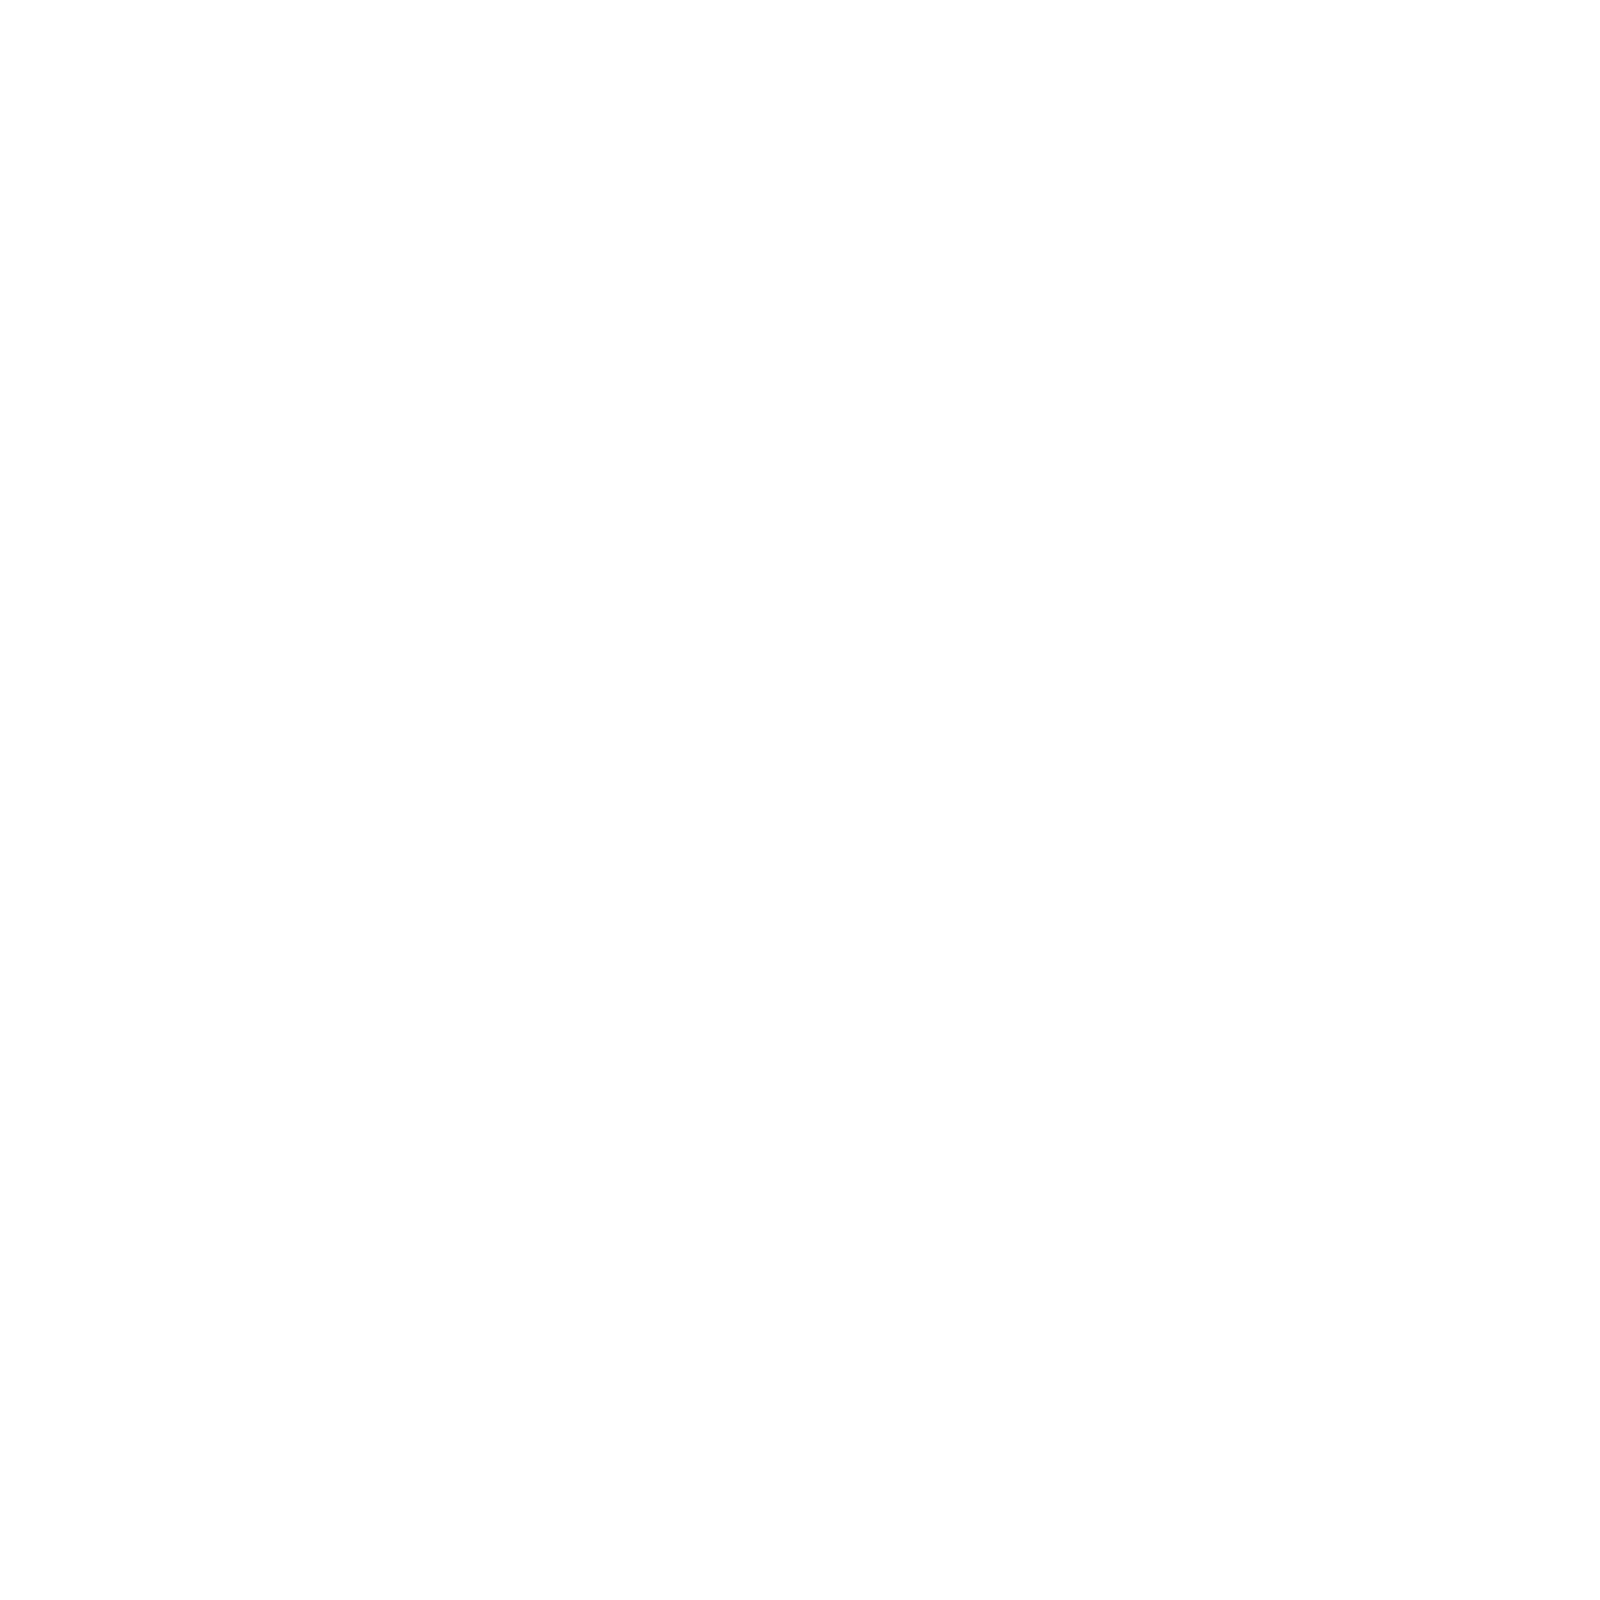

In [11]:
# Select the viewpoint using spherical angles  
distance = 3   # distance from camera to the object
elevation = 0.0   # angle of elevation in degrees
azimuth = 0.0  # angle of azimuth rotation in degrees

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

# Render the teapot providing the values of R and T. 
silhouette = silhouette_renderer(meshes_world=trg_mesh, R=R, T=T)
image_ref = phong_renderer(meshes_world=trg_mesh, R=R, T=T)

silhouette = silhouette.cpu().numpy()
image_ref = image_ref.cpu().numpy()

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(silhouette.squeeze()[..., 3])  # only plot the alpha channel of the RGBA image
plt.grid("off")
plt.subplot(1, 2, 2)
plt.imshow(image_ref.squeeze())
plt.grid("off")

## 3. Optimization loop 

In [12]:
# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in src_mesh
deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)

In [13]:
# The optimizer
optimizer = torch.optim.Adam([deform_verts], lr=1e-3)

In [14]:
# Targets
elevations, azimuths = [0., 89.999, 0.], [0., 0., 90.]
R_T_refs = [look_at_view_transform(3., R_ref, T_ref, device=device) for R_ref, T_ref in zip(elevations, azimuths)]
image_refs = torch.stack([silhouette_renderer(meshes_world=trg_mesh, R=R_ref, T=T_ref).squeeze()[..., 3] for R_ref, T_ref in R_T_refs], axis=0)

In [15]:
image_refs.shape

torch.Size([3, 256, 256])

<IPython.core.display.Javascript object>


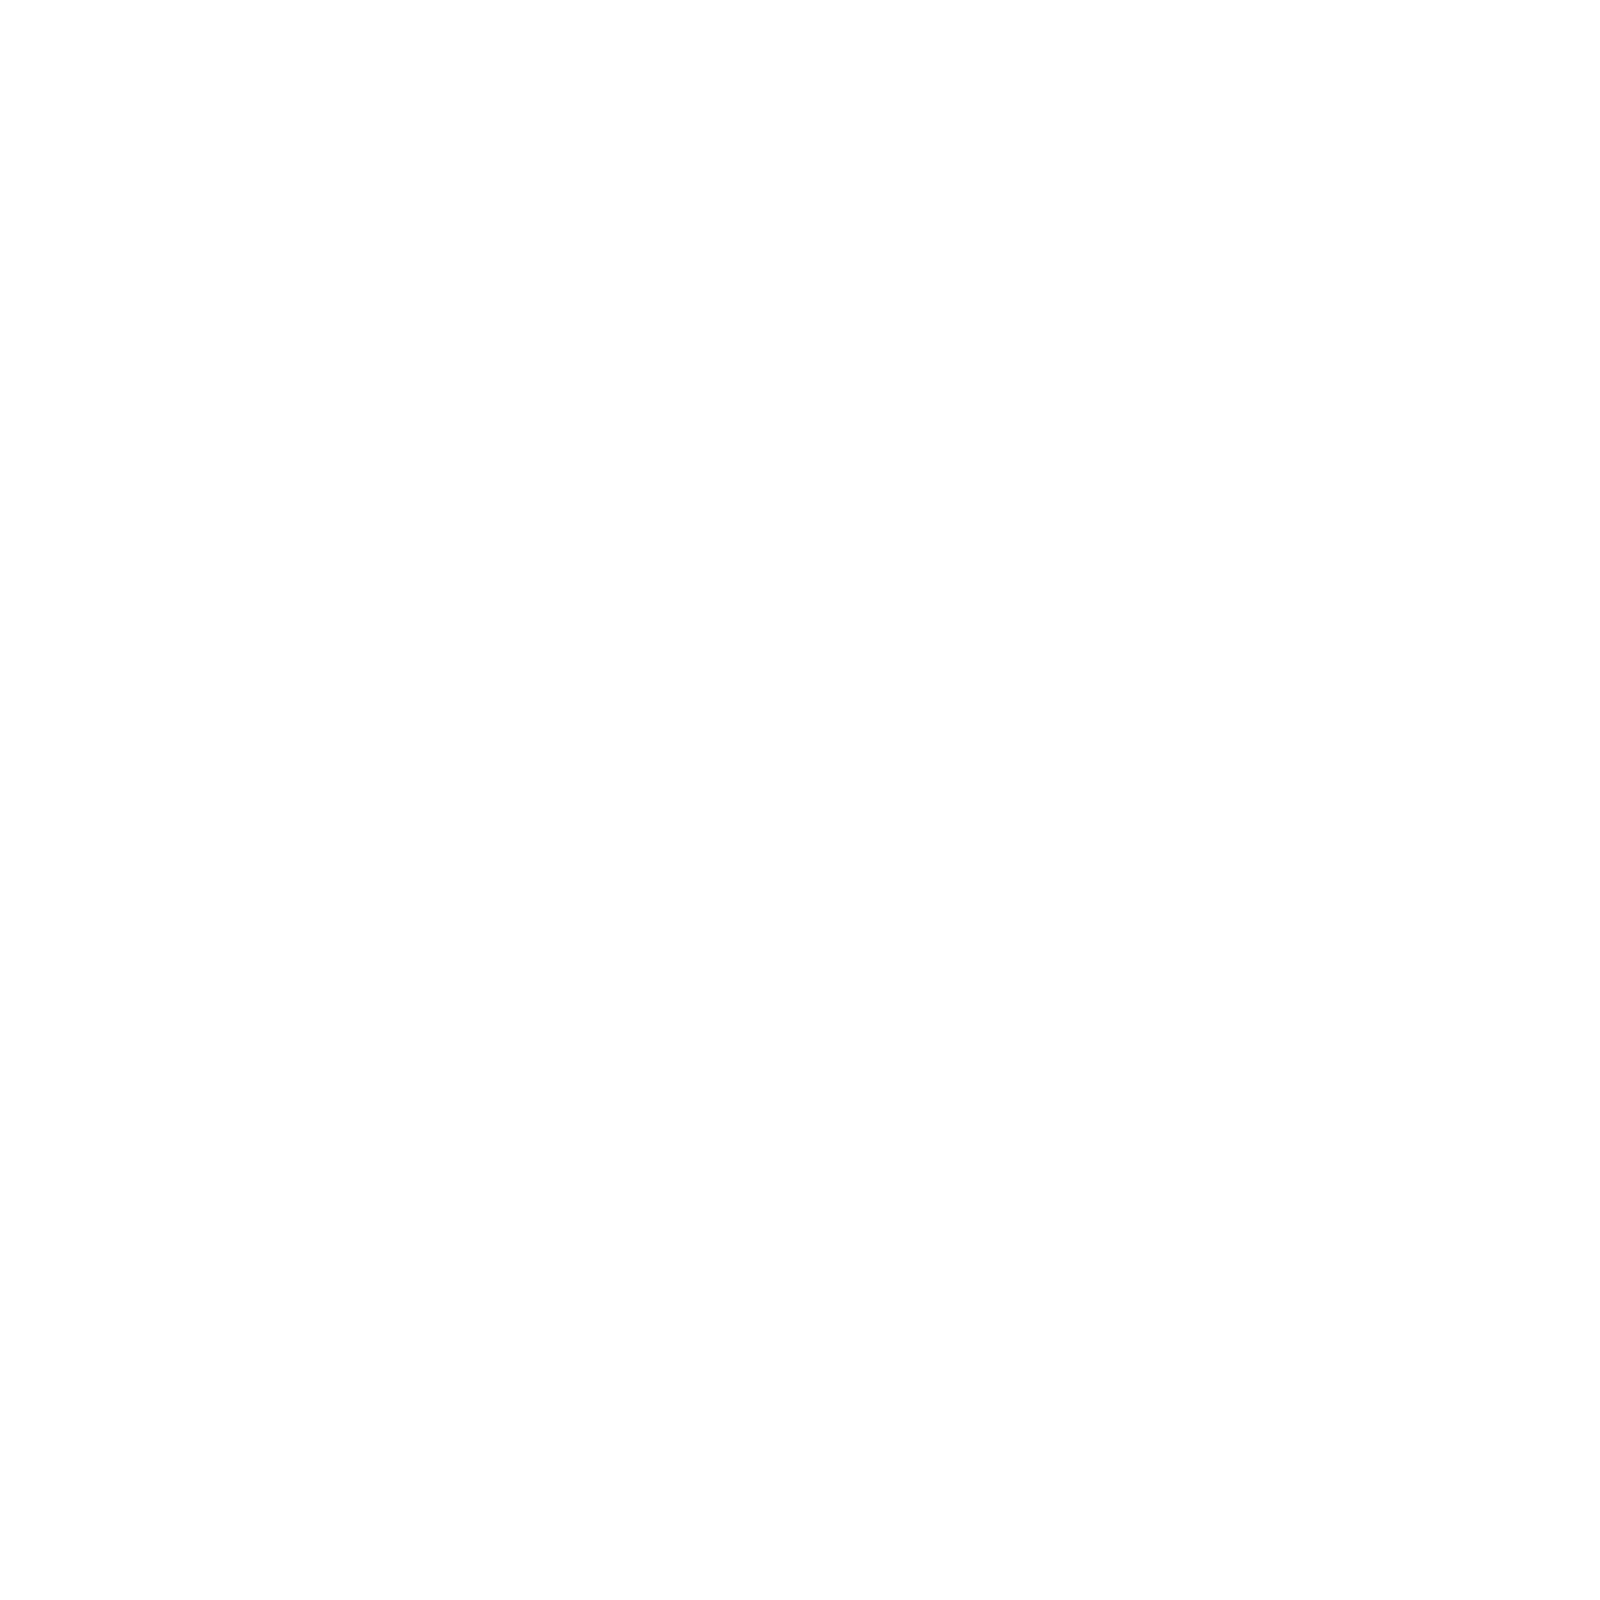

<IPython.core.display.Javascript object>


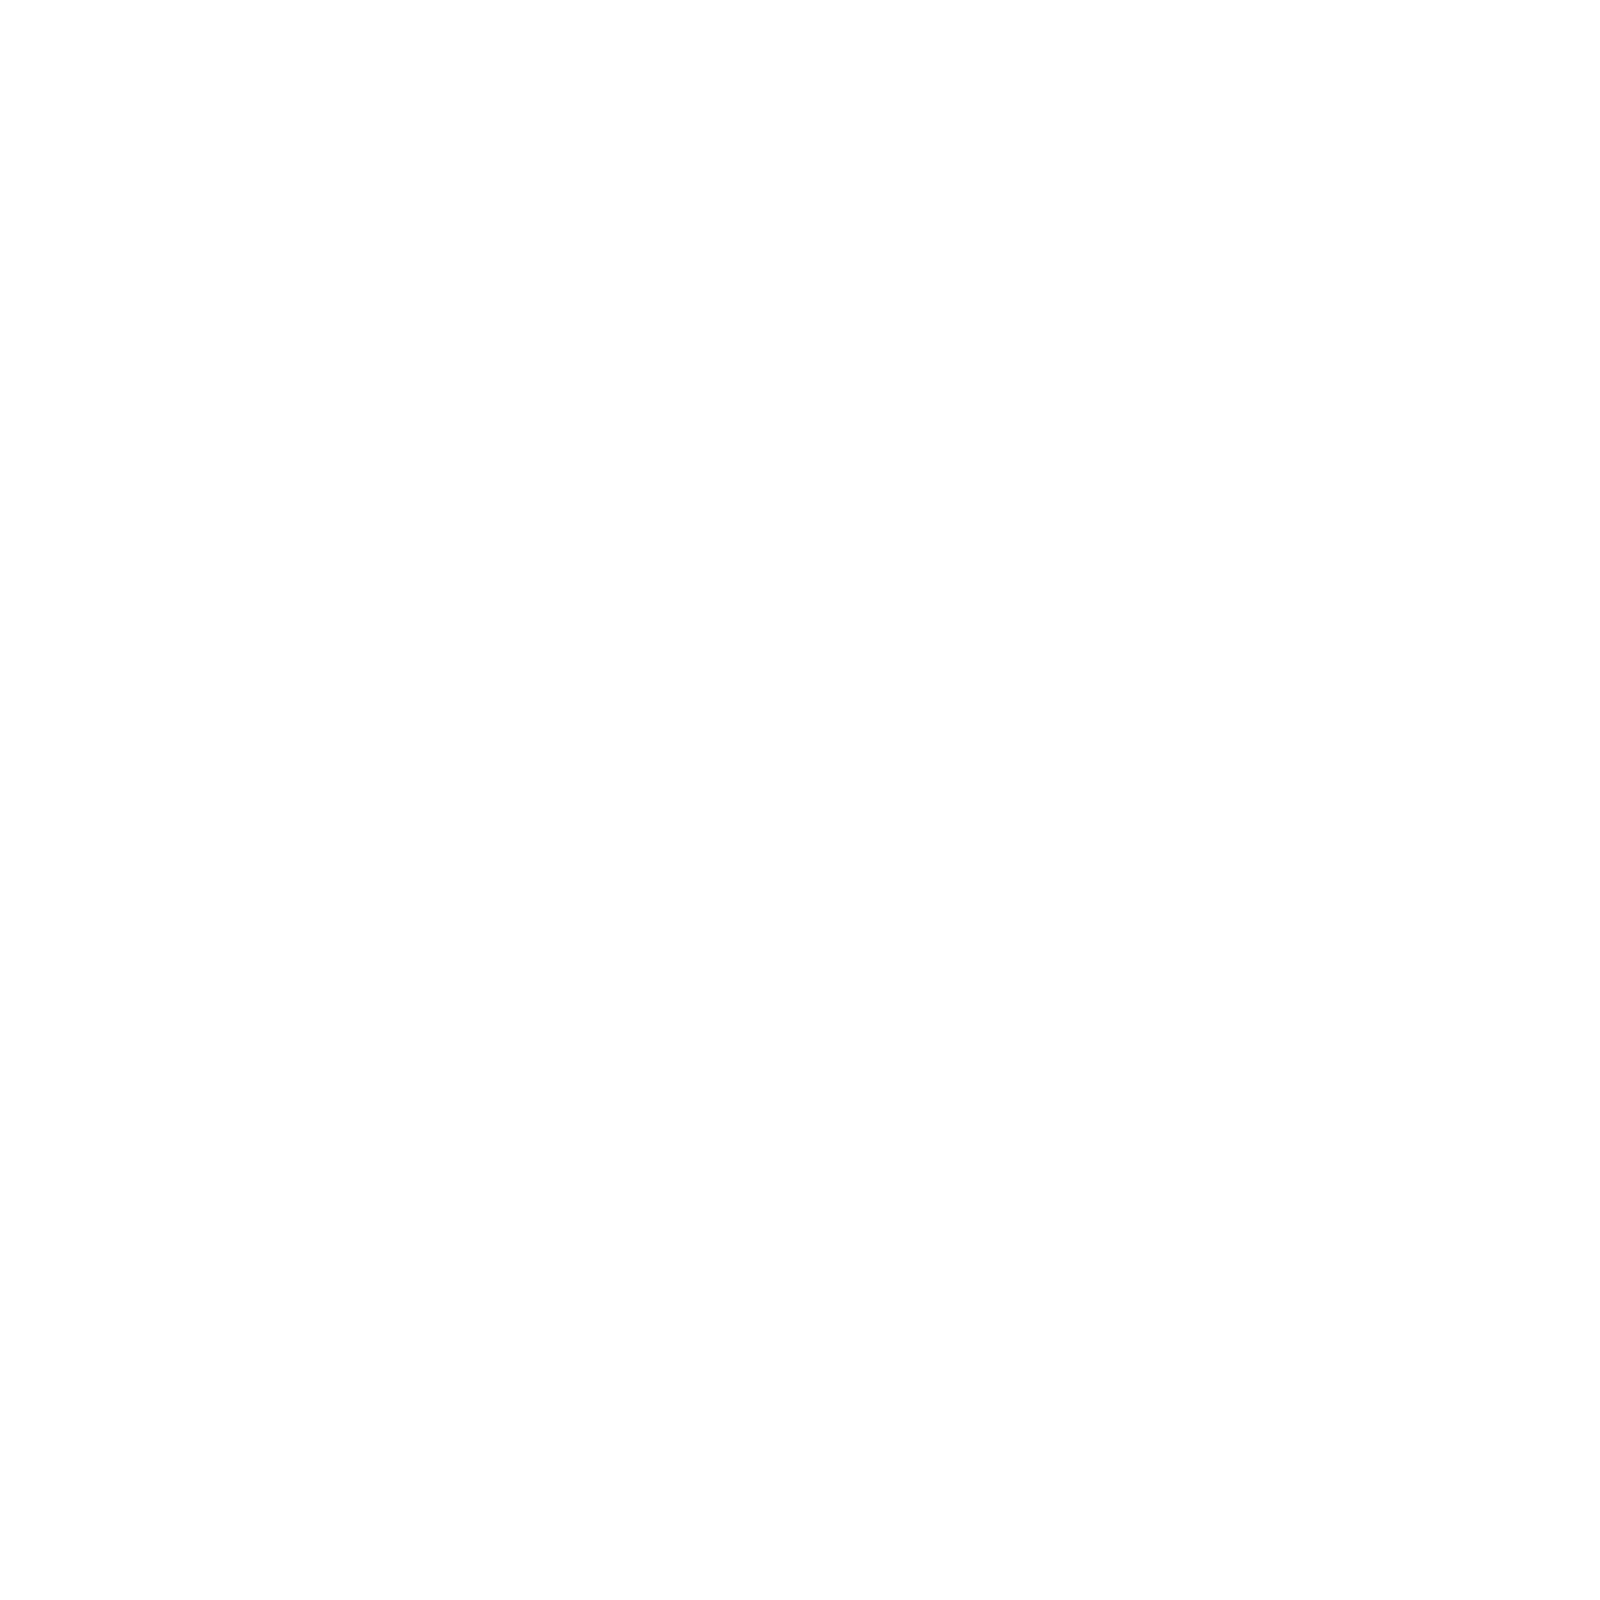

<IPython.core.display.Javascript object>


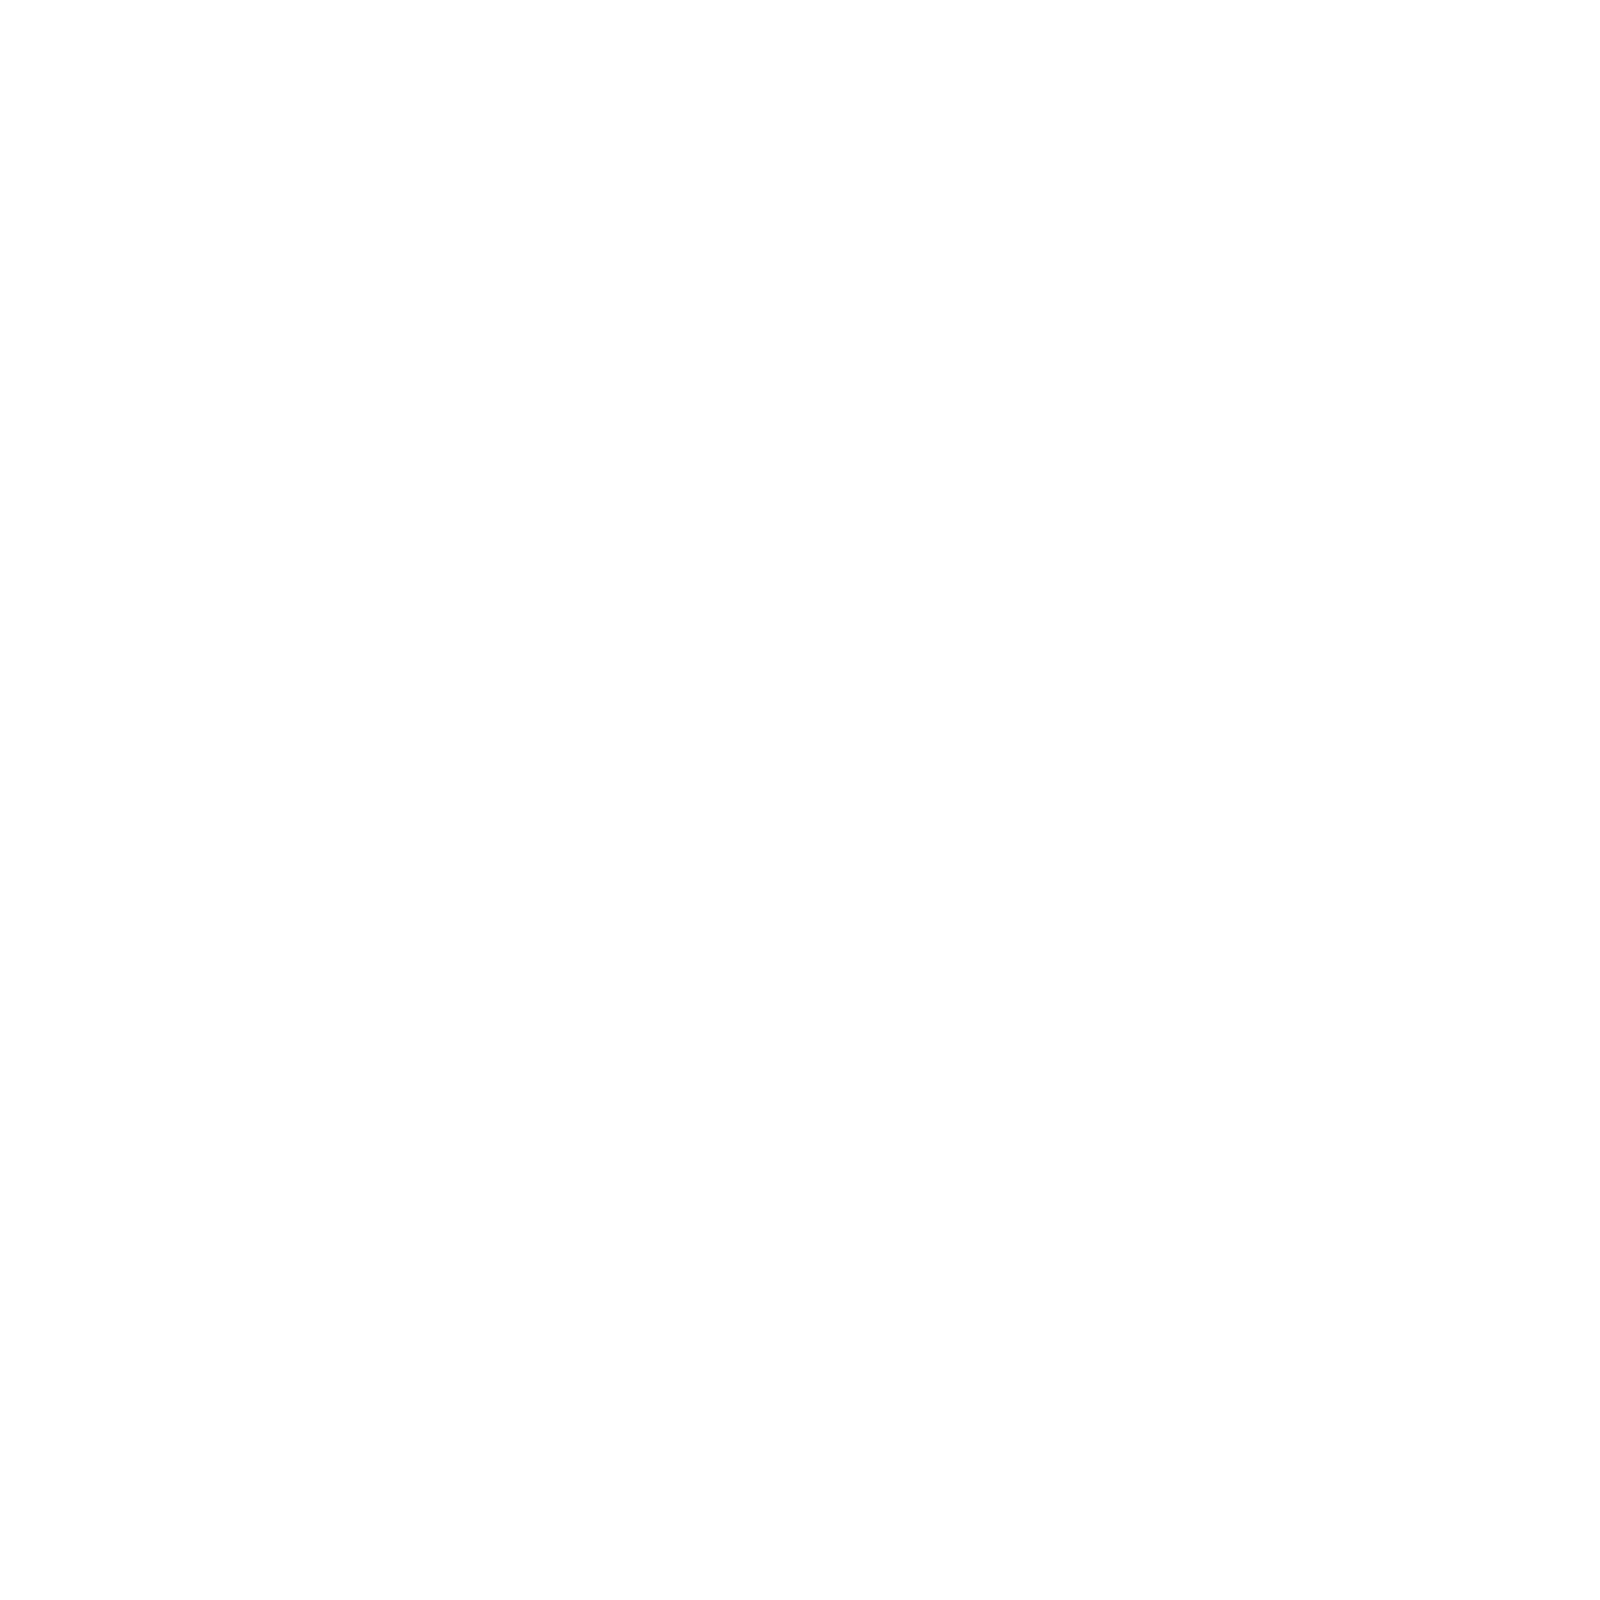

In [16]:
for i in range(3):
    plt.figure(figsize=(10, 10))
    plt.imshow(image_refs[i, ...].cpu().numpy())  # only plot the alpha channel of the RGBA image
    plt.grid("off")

/home/vil/coding/python/pytorch3d/env/lib/python3.7/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


tensor(0.0061, device='cuda:0', grad_fn=<SubBackward0>)


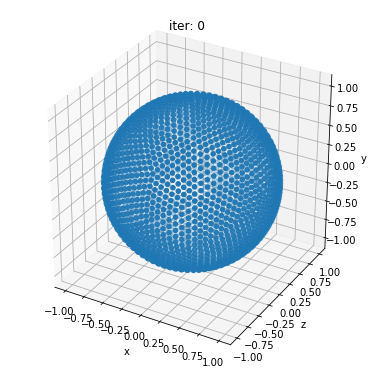

tensor(0.0063, device='cuda:0', grad_fn=<SubBackward0>)


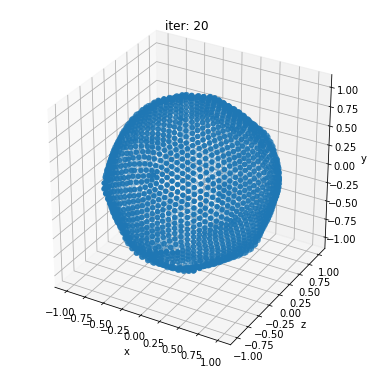

tensor(0.0064, device='cuda:0', grad_fn=<SubBackward0>)


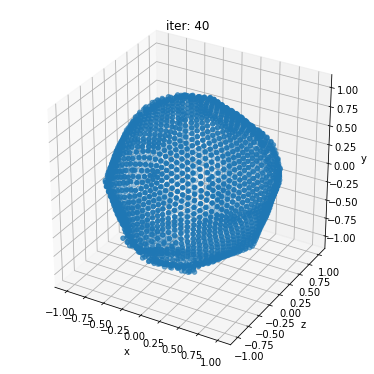

tensor(0.0065, device='cuda:0', grad_fn=<SubBackward0>)


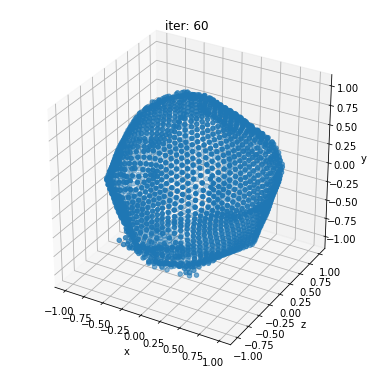

tensor(0.0066, device='cuda:0', grad_fn=<SubBackward0>)


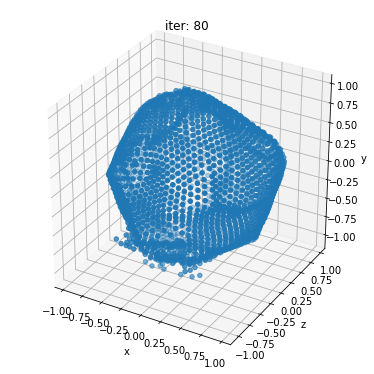

tensor(0.0068, device='cuda:0', grad_fn=<SubBackward0>)


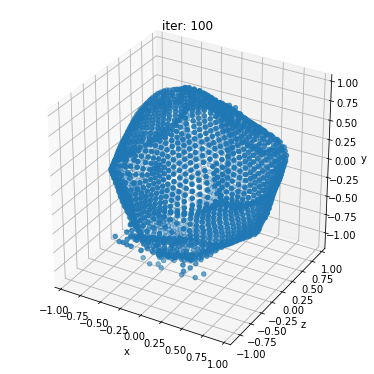

RuntimeError: cuda runtime error (710) : device-side assert triggered at /pytorch/aten/src/THC/THCGeneral.cpp:313

In [17]:
# Number of optimization steps
Niter = 2000
# Weight for the silhouette loss
w_silhouette = 1.0
# Weight for mesh edge loss
w_edge = 1.0 
# Weight for mesh normal consistency
w_normal = 0.01 
# Weight for mesh laplacian smoothing
w_laplacian = 0.1 
# Plot period for the losses
plot_period = 20
loop = tqdm_notebook(range(Niter))

silhouette_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

%matplotlib inline

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)
    
    # We sample 5k points from the surface of each mesh 
    sample_trg = sample_points_from_meshes(trg_mesh, 5000)
    dbg_valid = new_src_mesh.valid.cpu()
    dbg_packed = new_src_mesh.mesh_to_faces_packed_first_idx().cpu()
    #print('DBG {}'.format(dbg_valid))
    #print('DBG {}'.format(dbg_packed))
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)
        
    
    renders = torch.stack([silhouette_renderer(meshes_world=new_src_mesh, R=R_ref, T=T_ref).squeeze()[..., 3] for R_ref, T_ref in R_T_refs], axis=0)
    
    # We compare the two sets of pointclouds by computing (a) the silhouette loss
    loss_silhouette = torch.mean((renders - image_refs) ** 2)
    
    # For a cube
    #loss_silhouette = torch.mean(torch.relu(torch.max(torch.abs(sample_src[:, :, 0:2]), axis=2)[0]- 0.5))
    #loss_silhouette += torch.mean(torch.relu(torch.max(torch.abs(sample_src[:, :, 1:3]), axis=2)[0]- 0.5))
    #loss_silhouette += torch.mean(torch.relu(torch.max(torch.abs(sample_src[:, :, [0,2]]), axis=2)[0]- 0.5))
    
    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)
    
    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)
    
    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")
    
    # Weighted sum of the losses
    loss = loss_silhouette * w_silhouette + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian
    if i % plot_period == 0:
        print(loss - loss_silhouette * w_silhouette)
    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)
    
    # Save the losses for plotting
    silhouette_losses.append(loss_silhouette)
    edge_losses.append(loss_edge)
    normal_losses.append(loss_normal)
    laplacian_losses.append(loss_laplacian)
    
    # Plot mesh
    if i % plot_period == 0:
        plot_pointcloud(new_src_mesh, title="iter: %d" % i)
        
    # Optimization step
    loss.backward()
    optimizer.step()


## 4. Visualize the loss

## 5. Save the predicted mesh

## 6. Conclusion 

In this tutorial we learnt how to load a mesh from an obj file, initialize a PyTorch3d datastructure called **Meshes**, set up an optimization loop and use four different PyTorch3d mesh loss functions. 